# Modeling Drag Race Skill Using TrueSkill
## Data
* Scraped from wikipedia results
* Unpivoted into quen-season-episode results 
* Numerically ranked
* Season-episode rematched into psudo-bouts

## Method
* prepare dataste
* iterate dataset applying trueskill while recording
    * pre match prediction as a representation of assumptions at the time
* predict against dataset using trained rankings as a representation of assumptions looking back 
* test accuracy 
    * shuffled ROC
    * shuffled confusion matrix

## Analysis 
* top queens
* biggest result upsets
    * upsets at the time
    * upsets in retrospective
* predict the results of season 5 allstars
    * vs matrix
    * raw skill plot

## Data Prep

In [180]:
sdf = pd.read_csv("ass_dataset.csv")  # import allstarts drag race results
sdf = sdf[
    sdf["res1"] != sdf["res2"]
]  # did experement with including drawers, it reduces accuracy :(
sdf["rest"] = sdf["res1"]  # yep, I mislabled res in building_datasets
sdf["res1"] = sdf["res2"]
sdf["res2"] = sdf["rest"]
del sdf["rest"]
sdf["result"] = (sdf["res1"] < sdf["res2"]).astype(int)
sdf["s1"] = (sdf["res1"] < sdf["res2"]).astype(int)
sdf["s2"] = (sdf["res2"] < sdf["res1"]).astype(int)

In [181]:
odf = pd.read_csv("open_dataset.csv")  # import normal drag race results
odf = odf[odf["res1"] != odf["res2"]]
odf["rest"] = odf["res1"]
odf["res1"] = odf["res2"]
odf["res2"] = odf["rest"]
del odf["rest"]
odf["result"] = (odf["res1"] < odf["res2"]).astype(int)
odf["s1"] = (odf["res1"] < odf["res2"]).astype(int)
odf["s2"] = (odf["res2"] < odf["res1"]).astype(int)

In [182]:
odf = pd.concat([sdf, odf])
del odf["Unnamed: 0"]  # because I'm lazy and save with default indexes

In [183]:
odf = odf.drop_duplicates()

In [184]:
odf["season"] = [float(x.split(":")[0]) for x in odf["s:e"]]
odf["episode"] = [float(x.split(":")[1]) for x in odf["s:e"]]

In [185]:
odf = odf.sort_values(["season", "episode"])

In [186]:
odf.head()

,res1,res2,cont1,cont2,s:e,position1,position2,sorted,result,s1,s2,season,episode
0,3.00000,1.00000,Bebe Zahara Benet,Nina Flowers,1:1,SAFE,WIN,"[['Bebe Zahara Benet', 'Nina Flowers'], '1:1']",0,0,1,1.00000,1.00000
282,3.00000,1.00000,Tammie Brown,Nina Flowers,1:1,SAFE,WIN,"[['Nina Flowers', 'Tammie Brown'], '1:1']",0,0,1,1.00000,1.00000
284,3.00000,1.00000,Shannel,Nina Flowers,1:1,SAFE,WIN,"[['Nina Flowers', 'Shannel'], '1:1']",0,0,1,1.00000,1.00000
298,2.00000,1.00000,Ongina,Nina Flowers,1:1,HIGH,WIN,"[['Nina Flowers', 'Ongina'], '1:1']",0,0,1,1.00000,1.00000
309,6.00000,1.00000,"Victoria ""Porkchop"" Parker",Nina Flowers,1:1,ELIM,WIN,"[['Nina Flowers', 'Victoria ""Porkchop"" Parker'...",0,0,1,1.00000,1.00000


## Trueskill training

In [187]:
from trueskill import Rating, quality_1vs1, rate_1vs1
import trueskill
import itertools
import math

In [188]:
# why isnt this implemented in trueskill?!
def win_probability(team1, team2):
    average_sigma = (team1[0].sigma + team2[0].sigma) / 2
    BETA = average_sigma / 2
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    ts = trueskill.global_env()
    return ts.cdf(delta_mu / denom)

In [189]:
# build a dictionary of all queens
users = {
    x: Rating() for x in list(set(odf["cont1"].to_list() + odf["cont2"].to_list()))
}

In [190]:
## train model
# iterate through every psudo-bout, update rankings accordingly

pre_game_predictions = []
r1 = []
r2 = []
for c1, c2, s1, s2 in zip(odf["cont1"], odf["cont2"], odf["res1"], odf["res2"]):

    # pre match recording
    #     print(users[c1], users[c2])
    r1.append(users[c1])
    r2.append(users[c2])

    # predicting
    prediction = win_probability([users[c1]], [users[c2]])
    pre_game_predictions.append(prediction)
    #     print(prediction)  # draw probability

    # results
    winner = [c1, c2][[s1, s2].index(min([s1, s2]))]  # find winner
    loser = [c1, c2][[s1, s2].index(max([s1, s2]))]
    #     print(winner, loser)
    drawn = s1 == s2  # check for a drawer
    new_r1, new_r2 = rate_1vs1(
        users[winner], users[loser], drawn=drawn
    )  # update rankings
    #     print(new_r1, new_r2)

    # post match updating
    users[winner] = new_r1
    users[loser] = new_r2

#     break

In [191]:
post_training_predictions = []

for c1, c2, s1, s2 in zip(odf["cont1"], odf["cont2"], odf["res1"], odf["res2"]):
    prediction = win_probability([users[c1]], [users[c2]])
    post_training_predictions.append(prediction)

## Results and analyis 

### Training Data Accuracy

In [192]:
import matplotlib.pyplot as plt
from pycm import *
from sklearn.metrics import roc_curve, classification_report

In [193]:
odf["prediction"] = pre_game_predictions
odf["pt_preds"] = post_training_predictions
odf["binary_pred"] = (odf["prediction"] > 0.5).astype(int)
odf["pred_correct"] = (odf["binary_pred"] == odf["result"]).astype(int)
odf["r1"] = r1
odf["r2"] = r2
odf.head()

,res1,res2,cont1,cont2,s:e,position1,position2,sorted,result,s1,s2,season,episode,prediction,pt_preds,binary_pred,pred_correct,r1,r2
0,3.00000,1.00000,Bebe Zahara Benet,Nina Flowers,1:1,SAFE,WIN,"[['Bebe Zahara Benet', 'Nina Flowers'], '1:1']",0,0,1,1.00000,1.00000,0.50000,0.20325,1,0,"trueskill.Rating(mu=25.000, sigma=8.333)","trueskill.Rating(mu=25.000, sigma=8.333)"
282,3.00000,1.00000,Tammie Brown,Nina Flowers,1:1,SAFE,WIN,"[['Nina Flowers', 'Tammie Brown'], '1:1']",0,0,1,1.00000,1.00000,0.36024,0.00000,0,1,"trueskill.Rating(mu=25.000, sigma=8.333)","trueskill.Rating(mu=29.396, sigma=7.171)"
284,3.00000,1.00000,Shannel,Nina Flowers,1:1,SAFE,WIN,"[['Nina Flowers', 'Shannel'], '1:1']",0,0,1,1.00000,1.00000,0.27727,0.00008,0,1,"trueskill.Rating(mu=25.000, sigma=8.333)","trueskill.Rating(mu=31.957, sigma=6.464)"
298,2.00000,1.00000,Ongina,Nina Flowers,1:1,HIGH,WIN,"[['Nina Flowers', 'Ongina'], '1:1']",0,0,1,1.00000,1.00000,0.22354,0.00074,0,1,"trueskill.Rating(mu=25.000, sigma=8.333)","trueskill.Rating(mu=33.693, sigma=5.974)"
309,6.00000,1.00000,"Victoria ""Porkchop"" Parker",Nina Flowers,1:1,ELIM,WIN,"[['Nina Flowers', 'Victoria ""Porkchop"" Parker'...",0,0,1,1.00000,1.00000,0.18634,0.00000,0,1,"trueskill.Rating(mu=25.000, sigma=8.333)","trueskill.Rating(mu=34.974, sigma=5.608)"


In [194]:
rand = [np.random.randint(2) for x in range(len(odf))]
y = [x + r for x, r in zip(odf["result"], rand)]
y_pred = [abs(r - x) for x, r in zip(odf["prediction"], rand)]
y_int = [int(x > 0.5) for x in y_pred]

In [195]:
# calculate confusion matrix using https://www.pycm.ir/doc/index.html#Usage
cm = ConfusionMatrix(y, y_int)
print(cm)

Predict    0          1          
Actual
0          3993       681        

1          669        4043       





Overall Statistics : 

95% CI                                                            (0.84907,0.86327)
ACC Macro                                                         0.85617
AUNP                                                              0.85616
AUNU                                                              0.85616
Bennett S                                                         0.71234
CBA                                                               0.85507
CSI                                                               0.71233
Chi-Squared                                                       4762.61695
Chi-Squared DF                                                    1
Conditional Entropy                                               0.59416
Cramer V                                                          0.71233
Cross Entropy                            

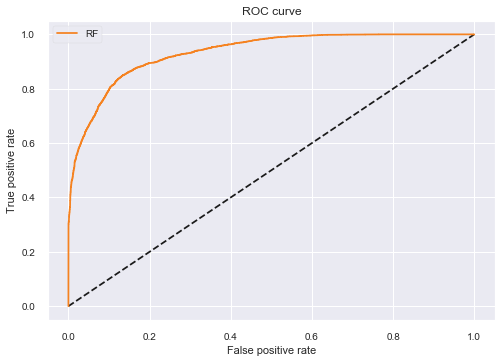

In [196]:
# build ROC curve (closer to top left is better)
fpr_rf, tpr_rf, _ = roc_curve(y, y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr_rf, tpr_rf, label="RF")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend(loc="best")
plt.show()

### Overall rankings

In [197]:
## top queens
# full results are in trueskill_summary.csv
summary = pd.DataFrame(users).T
summary.columns = ["rating", "uncertainty"]
summary = summary.sort_values("rating", ascending=False)
summary.head(15)

,rating,uncertainty
Jinkx Monsoon,35.02682,1.12313
Shea Couleé,33.31276,1.10195
Sasha Velour,33.19470,1.03827
Nina Flowers,33.09661,1.21995
Alaska,32.56031,1.03196
Sharon Needles,32.53998,1.06765
Chad Michaels,32.50983,1.11961
Bob the Drag Queen,32.02848,1.17629
Roxxxy Andrews,32.00112,1.01420
Raja,31.86649,0.96499


### biggest upsets at the time

In [198]:
# based on the pre-match predictions
odf.dropna().sort_values("prediction", ascending=False)[
    ["cont1", "cont2", "position1", "position2", "prediction", "s:e"]
].head(10)

,cont1,cont2,position1,position2,prediction,s:e
4,Morgan McMichaels,Sahara Davenport,SAFE,WIN,1.00000,2:2
462,Alexis Mateo,Delta Work,BTM2,HIGH,1.00000,3:7
822,Mimi Imfurst,Delta Work,ELIM,SAFE,1.00000,3:4
371,Tyra Sanchez,Raven,LOW,HIGH,1.00000,2:6
4925,Thorgy Thor,Cynthia Lee Fontaine,Guest,Miss C,1.00000,8:10.0
4913,Derrick Barry,Cynthia Lee Fontaine,Guest,Miss C,1.00000,8:10.0
4943,Chi Chi DeVayne,Cynthia Lee Fontaine,Guest,Miss C,1.00000,8:10.0
400,Morgan McMichaels,Mystique Summers Madison,SAFE,HIGH,1.00000,2:2
5591,Trinity Taylor,Cynthia Lee Fontaine,BTM2,SAFE,1.00000,9:4.0
87,Ongina,Rebecca Glasscock,ELIM,WIN,1.00000,1:5


### biggest upsets in retrospective

In [199]:
# based on the fully trained model
odf.dropna().sort_values("pt_preds", ascending=False)[
    ["cont1", "cont2", "position1", "position2", "prediction", "s:e"]
].head(10)

,cont1,cont2,position1,position2,prediction,s:e
3785,Yara Sofia,Mimi Imfurst,SAFE,HIGH,0.02396,3:2.0
4130,Manila Luzon,Mariah,SAFE,HIGH,0.33951,3:3.0
6833,Raven,Sonique,BTM2,LOW,0.52736,2:2.0
548,Alexis Mateo,Mimi Imfurst,SAFE,HIGH,0.17500,3:2
4004,A'Keria Chanel Davenport,Mercedes Iman Diamond,BTM6,HIGH,0.99981,11:3.0
6727,Brooke Lynn Hytes,Honey Davenport,LOW,SAFE,0.73222,11:2.0
3759,Raven,Mystique Summers Madison,BTM2,HIGH,0.10837,2:2.0
3437,Aquaria,Yuhua Hamasaki,SAFE,HIGH,0.04422,10:1.0
4123,Manila Luzon,Mimi Imfurst,SAFE,HIGH,0.04435,3:3.0
4666,Shangela,Phoenix,BTM2,SAFE,0.01769,3:2.0


### Season 5 results prediction

In [200]:
season_5_queens = [
    "Alexis Mateo",
    "Blair St. Clair",
    "Derrick Barry",
    "India Ferrah",
    "Jujubee",
    "Mariah",
    "Mayhem Miller",
    "Miz Cracker",
    "Ongina",
    "Shea Couleé",
]
as5_1 = []
as5_2 = []
pred = []
for x in season_5_queens:
    for y in season_5_queens:
        as5_1.append(x)
        as5_2.append(y)
        pred.append(win_probability([users[x]], [users[y]]))

season_5_res = pd.DataFrame({"as5_1": as5_1, "as5_2": as5_2, "win_prediction": pred})
season_5_res = season_5_res.pivot(
    index="as5_1", columns="as5_2", values="win_prediction"
)
season_5_res["mean"] = season_5_res.mean(axis=1)
season_5_res = season_5_res.sort_values("mean", ascending=False)
del season_5_res["mean"]
print("Interpreted as probability that queen on the side beats the queen along top.")
print("e.g. Shea has a 0.978 liklihood to get a result higher than Alexis")
season_5_res[season_5_res.index].round(3).style.background_gradient("Blues")

Interpreted as probability that queen on the side beats the queen along top.
e.g. Shea has a 0.978 liklihood to get a result higher than Alexis


as5_2,Shea Couleé,Alexis Mateo,Jujubee,Miz Cracker,Ongina,Derrick Barry,Blair St. Clair,Mayhem Miller,Mariah,India Ferrah
as5_1,,,,,,,,,,
Shea Couleé,0.5,0.978,1,1,1,1,1,1,1,1
Alexis Mateo,0.022,0.5,0.959,0.964,0.964,0.998,1,1,1,1
Jujubee,0,0.041,0.5,0.542,0.624,0.908,1,1,1,1
Miz Cracker,0,0.036,0.458,0.5,0.586,0.885,1,1,1,1
Ongina,0,0.036,0.376,0.414,0.5,0.806,1,1,1,1
Derrick Barry,0,0.002,0.092,0.115,0.194,0.5,0.996,1,1,1
Blair St. Clair,0,0,0,0,0,0.004,0.5,0.959,0.982,1
Mayhem Miller,0,0,0,0,0,0,0.041,0.5,0.619,0.979
Mariah,0,0,0,0,0,0,0.018,0.381,0.5,0.964


From first impressions: 
* The first 4 episodes will be the weaker queens being eliminated quite convincingly. The order will likely be: 
    1. India
    1. Maria (but likely a close call against Mayhem)
    1. Mayhem
    1. Blair
* The top 3 is likely to include Shea, Alexis, Jujubee, Miz Cracker or Ongina. 
* Shea is very likely to win. 

,queen,skill
9,Shea Couleé,33.31276
0,Alexis Mateo,30.05750
4,Jujubee,27.48919
7,Miz Cracker,27.33144
8,Ongina,26.94945
2,Derrick Barry,25.37079
1,Blair St. Clair,20.93533
6,Mayhem Miller,17.98620
5,Mariah,17.46983
3,India Ferrah,14.25587


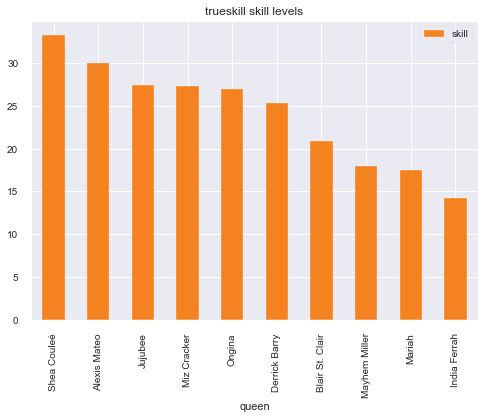

In [201]:
season_5_skill = pd.DataFrame()
season_5_skill["queen"] = season_5_queens
season_5_skill["trueskill"] = season_5_skill["queen"].map(users)
season_5_skill["skill"] = [x.mu for x in season_5_skill["trueskill"]]
display(season_5_skill.sort_values("skill", ascending=False)[["queen", "skill"]])
season_5_skill.sort_values("skill", ascending=False).set_index("queen")[
    ["skill"]
].plot.bar(title="trueskill skill levels")

## Saving

In [202]:
odf.to_csv("trueskil_results.csv")

In [203]:
summary.to_csv("trueskill_summary.csv")